In [31]:
import pandas as pd
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_rows', 10)

# 1. Merge mutiple csvs into a whole

In [32]:
csvs = []

def read_whole():
    _fn = os.listdir('./data')
    global csvs 
    for i, v in enumerate(_fn):
        csvs.append(pd.read_csv('./data/' + v))
        
read_whole()
merged = pd.concat(csvs)
# print(merged.head())
print(merged[['title', 'comp_name', 'category']].head())

if not os.path.exists('./data/_merged.csv'):
    merged.to_csv('./data/_merged.csv', index=False)

                       title    comp_name                         category
0            코덱 SW 엔지니어 (신입)          블루닷  영상,음성 엔지니어|머신러닝 엔지니어|소프트웨어 엔지니어
1              ML Researcher         메이아이       데이터 엔지니어|파이썬 개발자|머신러닝 엔지니어
2                    백엔드 개발자  아바티(AVATYE)         서버 개발자|웹 개발자|Node.js 개발자
3        코덱 엔지니어 (화질분석) (신입)          블루닷  영상,음성 엔지니어|머신러닝 엔지니어|소프트웨어 엔지니어
4  [전문연구요원 가능] 영상처리 개발자 (신입)        메디인테크     파이썬 개발자|C,C++ 개발자|소프트웨어 엔지니어


# 2. Remove duplicated

## 2-1. Shingling

In [33]:
def shinglation(col):
    ary = []
    for item in col:
        _tmp = []
        for idx in range(0, len(item) - 1):
            _tmp.append(item[idx] + item[idx + 1])
        ary.append(_tmp)
    return ary

In [34]:
title_array = pd.array(merged['title'])
title_shingle = shinglation(title_array)
print(len(title_shingle))

743


In [35]:
comp_name_array = pd.array(merged['comp_name'])
comp_name_shingle = shinglation(comp_name_array)
print(len(comp_name_shingle))

743


## 2-2. Jaccard Similarity

### 2-2-1. Get proper threshold (by title)

In [36]:
def jaccard(shingles, array, threshold):
    count = 0
    for i in range(0, len(shingles) - 1):
        for j in range(i + 1, len(shingles)):
            set1 = set(shingles[i])
            set2 = set(shingles[j])
            
            intersect = len(set1.intersection(set2))
            union = len(set1.union(set2))
            
            if union > 0 and (intersect / union) > threshold:
                # print("i: " + array[i] + "\n" + "j: " + array[j] + "\n\n")
                count += 1
    
    return count

In [37]:
# JAC_TITLE_THRESHOLD = 0.07
# JAC_COMP_NAME_THRESHOLD = 0.5

# estimate_th = 0.01
estimate_th = 0.18
estimate_th_x = []
estimate_th_y = []

# while estimate_th <= 0.5:
while estimate_th <= 0.4:
    estimate_th += 0.01
    print(estimate_th)
    cnt_title = jaccard(title_shingle, title_array, estimate_th)
    estimate_th_x.append(estimate_th)
    estimate_th_y.append(cnt_title)
    
print(estimate_th_x, estimate_th_y)


0.19
0.2
0.21000000000000002
0.22000000000000003
0.23000000000000004
0.24000000000000005
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
[0.19, 0.2, 0.21000000000000002, 0.22000000000000003, 0.23000000000000004, 0.24000000000000005, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002] [16009, 13568, 12696, 11038, 9840, 8458, 7108, 6684, 6002, 5287, 4832, 4258, 3942, 3553, 3420, 2899, 2705, 2508, 2299, 2055, 1916, 1678]


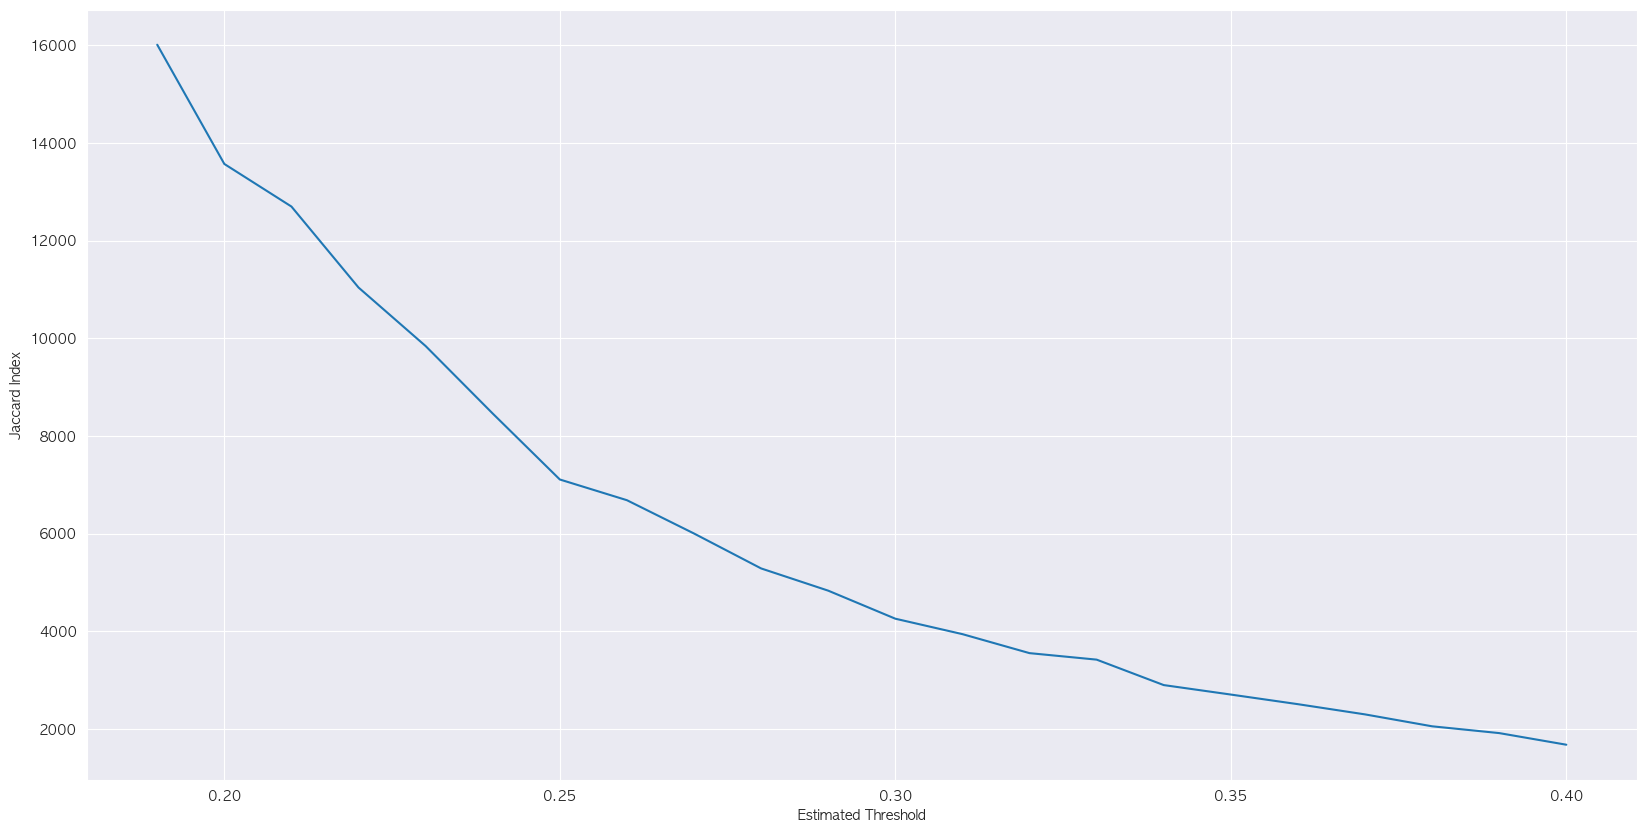

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(estimate_th_x, estimate_th_y)
plt.xlabel('Estimated Threshold')
plt.ylabel('Jaccard Index')
plt.show()

In [39]:
print(jaccard(title_shingle, title_array, 0))
# 가능한 자카드 쌍 = 1486 * 1485 = 1103355
# th가 0일때 563851 쌍 (51.5%)는 최소 한 개 이상의 교집합을 가짐

141947


Elbow point found at threshold = 0.250


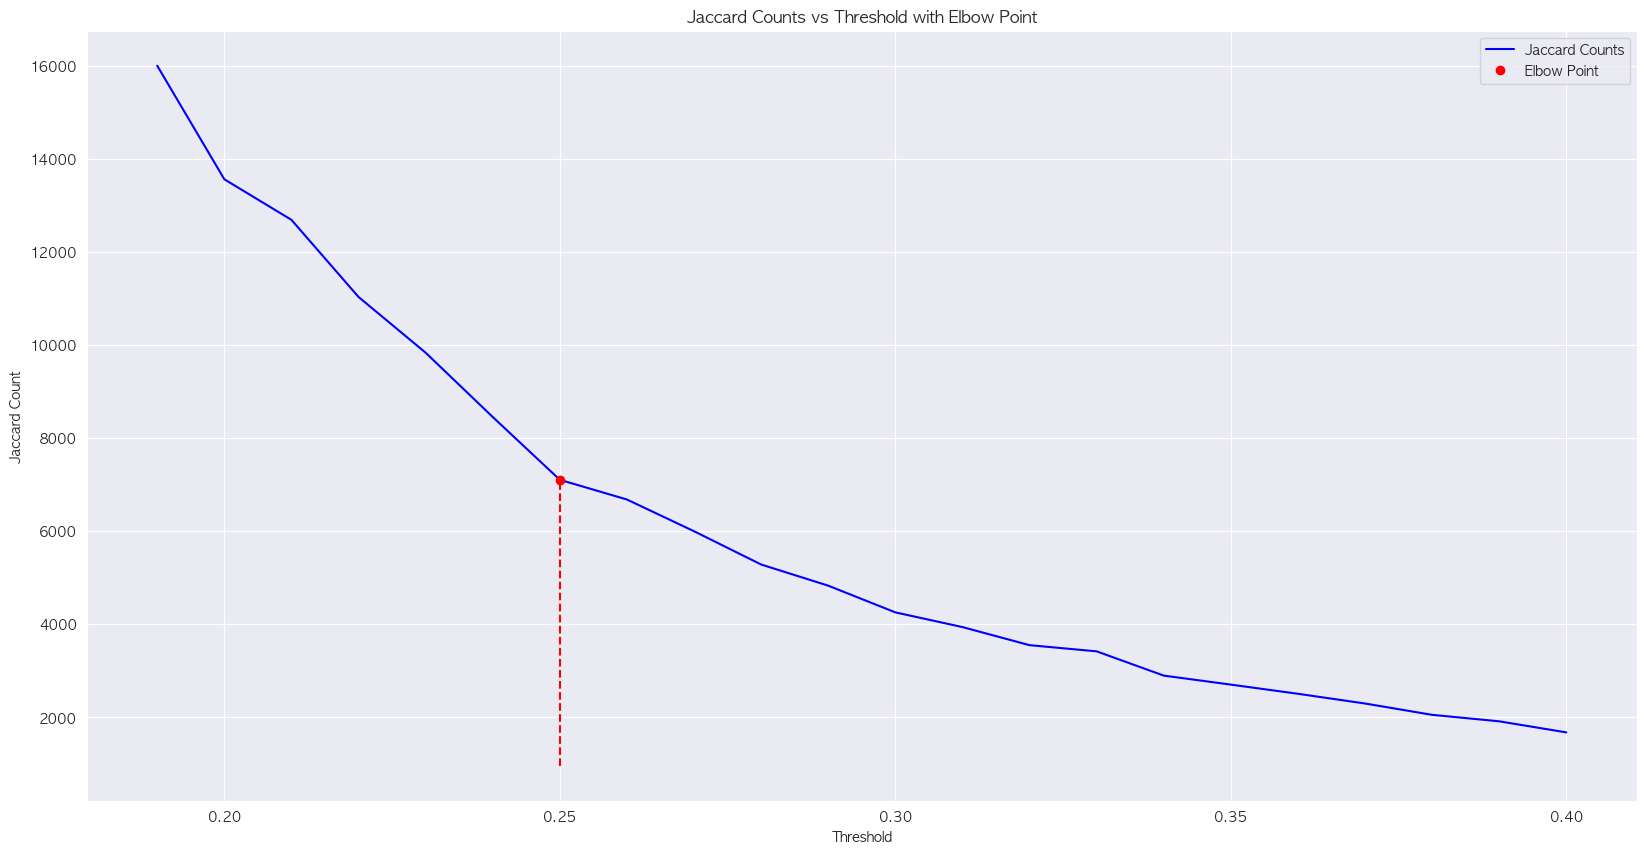

In [40]:
import numpy as np

def find_elbow(x, y):
    x = np.array(x)
    y = np.array(y)
    
    x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    coordinates = np.column_stack((x_normalized, y_normalized))
    angles = np.zeros(len(coordinates)-2)
    
    for i in range(1, len(coordinates)-1):
        point_before = coordinates[i-1]
        point = coordinates[i]
        point_after = coordinates[i+1]
        
        vector1 = point - point_before
        vector2 = point_after - point
        
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 > 0 and norm2 > 0:
            cos_angle = np.dot(vector1, vector2) / (norm1 * norm2)
            angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
            angles[i-1] = angle
    
    elbow_idx = np.argmax(angles) + 1
    
    return x[elbow_idx], y[elbow_idx], elbow_idx

elbow_x, elbow_y, idx = find_elbow(estimate_th_x, estimate_th_y)

plt.figure(figsize=(20, 10))
plt.plot(estimate_th_x, estimate_th_y, 'b-', label='Jaccard Counts')
plt.plot(elbow_x, elbow_y, 'ro', label='Elbow Point')
plt.vlines(elbow_x, plt.ylim()[0], elbow_y, linestyles='dashed', colors='r')

plt.xlabel('Threshold')
plt.ylabel('Jaccard Count')
plt.title('Jaccard Counts vs Threshold with Elbow Point')
plt.legend()
plt.grid(True)

print(f"Elbow point found at threshold = {elbow_x:.3f}")
plt.show()

### 2-2-2. Get proper threshold (by comp_name)

In [41]:
# estimate_th = 0.01
estimate_th = 0.15
estimate_th_x = []
estimate_th_y = []

# while estimate_th <= 0.5:
while estimate_th <= 0.35:
    estimate_th += 0.01
    print(estimate_th)
    cnt_comp_name = jaccard(comp_name_shingle, comp_name_array, estimate_th)
    estimate_th_x.append(estimate_th)
    estimate_th_y.append(cnt_comp_name)
    
print(estimate_th_x, estimate_th_y)


0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
[0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014] [3450, 3038, 3034, 2857, 2512, 2512, 2508, 2341, 2307, 2082, 2082, 2082, 2023, 1915, 1819, 1806, 1804, 1804, 1378, 1378]


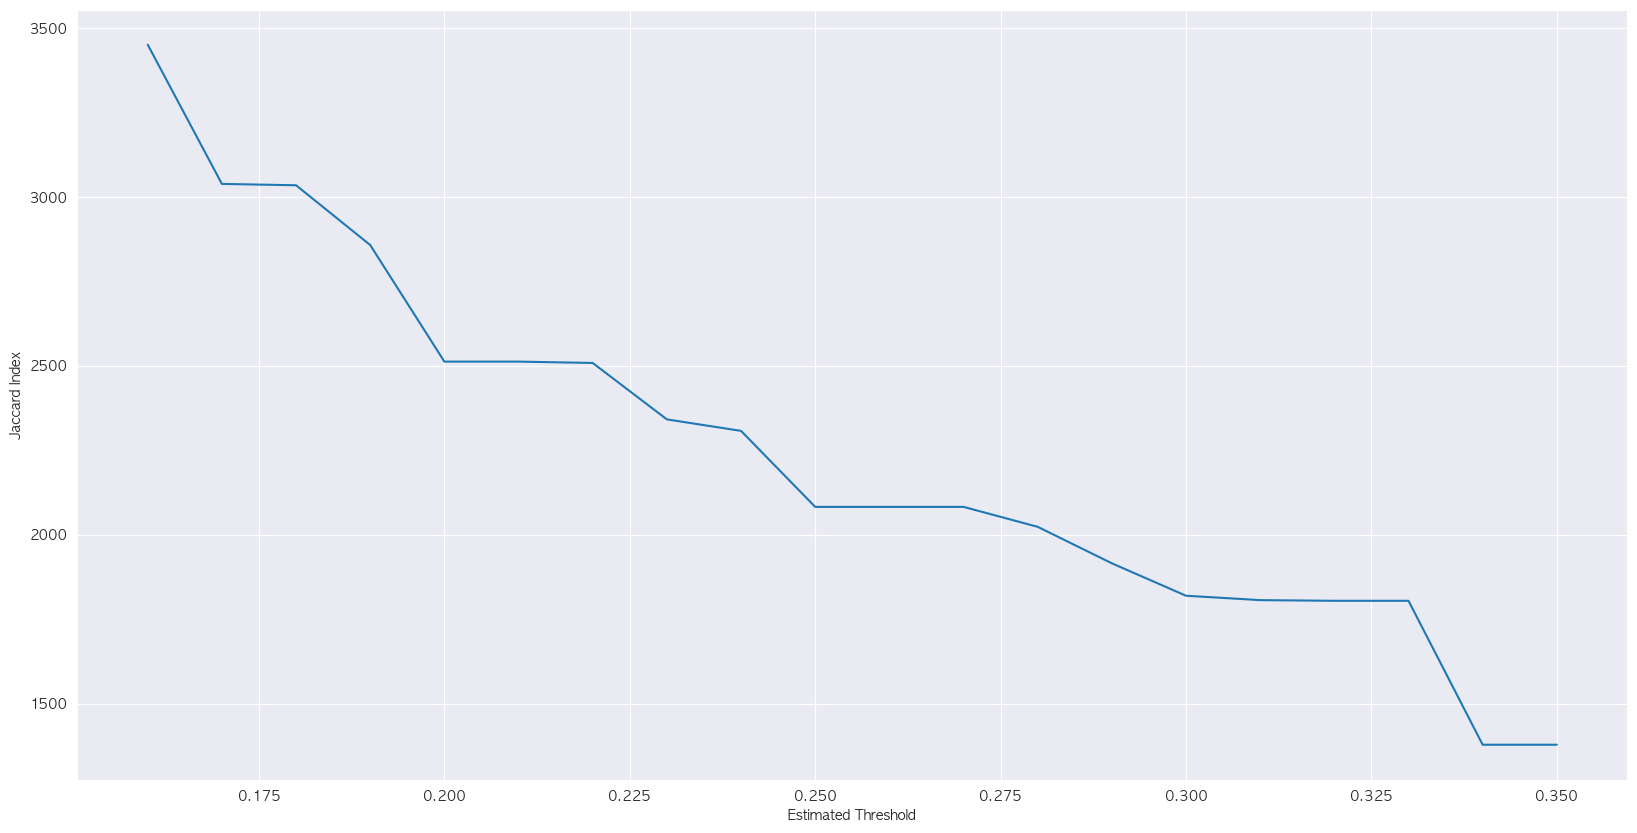

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(estimate_th_x, estimate_th_y)
plt.xlabel('Estimated Threshold')
plt.ylabel('Jaccard Index')
plt.show()

In [43]:
print(jaccard(comp_name_shingle, comp_name_array, 0))
# 가능한 자카드 쌍 = 1486 * 1485 = 1103355
# th가 0일때 563851 쌍 (51.5%)는 최소 한 개 이상의 교집합을 가짐

9090


Elbow point found at threshold = 0.330


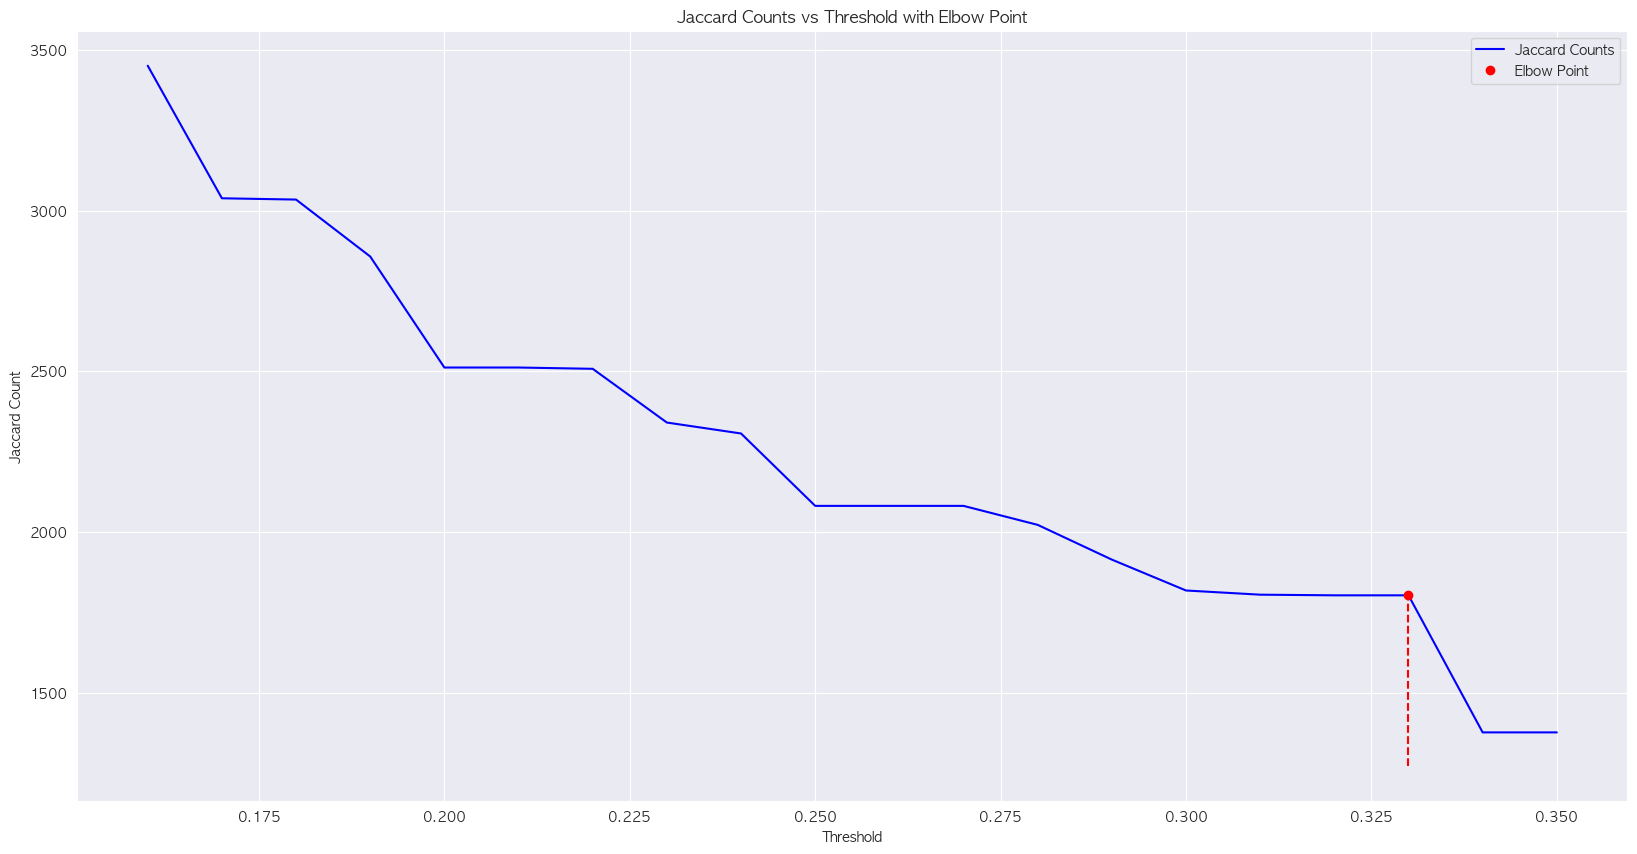

In [44]:
elbow_x, elbow_y, idx = find_elbow(estimate_th_x, estimate_th_y)

plt.figure(figsize=(20, 10))
plt.plot(estimate_th_x, estimate_th_y, 'b-', label='Jaccard Counts')
plt.plot(elbow_x, elbow_y, 'ro', label='Elbow Point')
plt.vlines(elbow_x, plt.ylim()[0], elbow_y, linestyles='dashed', colors='r')

plt.xlabel('Threshold')
plt.ylabel('Jaccard Count')
plt.title('Jaccard Counts vs Threshold with Elbow Point')
plt.legend()
plt.grid(True)

print(f"Elbow point found at threshold = {elbow_x:.3f}")
plt.show()

### 2-2-3. Remove duplicated based on the elbow threshold

In [45]:
def deletion_dup():
    count = 0
    seen_pairs = set()
    dup_list = []
    
    for i in range(0, len(title_shingle) - 1):
        for j in range(i + 1, len(title_shingle)):
            pair_key = f"{title_array[i]}_{title_array[j]}"
            if pair_key in seen_pairs:
                continue
    
            set_title_i = set(title_shingle[i])
            set_title_j = set(title_shingle[j])
            set_comp_name_i = set(comp_name_shingle[i])
            set_comp_name_j = set(comp_name_shingle[j])
    
            intersect_title = len(set_title_i.intersection(set_title_j))
            union_title = len(set_title_i.union(set_title_j))
            intersect_comp_name = len(set_comp_name_i.intersection(set_comp_name_j))
            union_comp_name = len(set_comp_name_i.union(set_comp_name_j))
    
    
            if union_title > 0 and union_comp_name > 0 and (intersect_title / union_title) > 0.2 and (intersect_comp_name / union_comp_name) > 0.33:
                print(f"title_i : {title_array[i]} \ntitle_j : {title_array[j]} \ncomp_name_i: {comp_name_array[i]} \ncomp_name_j : {comp_name_array[j]} \n\n")
                count += 1
                # 확인한 쌍 저장
                seen_pairs.add(pair_key)
                dup_list.append(i)
    return count, dup_list

# count, dup_list = deletion_dup()

# print(count)
# print(type(merged))
# 
# print(f"제거 전 데이터 수: {len(merged)}")
# merged = merged.drop(dup_list)
# print(f"제거 후 데이터 수: {len(merged)}")

# 3. LSH

In [46]:
# 자카드 유사도 O(n^2) 방식의 대안 

In [47]:
import numpy as np
from collections import defaultdict

class MinHash:
    def __init__(self, num_perm=128):
        self.num_perm = num_perm
        self.a = np.random.randint(1, pow(2, 32), num_perm)
        self.b = np.random.randint(0, pow(2, 32), num_perm)
        self.prime = 4294967311  # 2^32 - 5
        
    def hash_function(self, x, seed_a, seed_b):
        return (seed_a * x + seed_b) % self.prime
    
    def compute(self, word_set):
        min_hash = np.full(self.num_perm, np.inf)
        for word in word_set:
            hash_val = hash(word) & 0xffffffff
            for i in range(self.num_perm):
                hash_i = self.hash_function(hash_val, self.a[i], self.b[i])
                min_hash[i] = min(min_hash[i], hash_i)
        return min_hash

class LSH:
    def __init__(self, num_perm=128, num_bands=16):
        self.num_perm = num_perm
        self.num_bands = num_bands
        self.rows_per_band = num_perm // num_bands
        self.hash_tables = [defaultdict(list) for _ in range(num_bands)]
        self.minhash = MinHash(num_perm)
        
    def insert(self, idx, text_set):
        signature = self.minhash.compute(text_set)
        
        for i in range(self.num_bands):
            start = i * self.rows_per_band
            end = start + self.rows_per_band
            
            band = tuple(signature[start:end])
            self.hash_tables[i][band].append(idx)
    
    def query(self, text_set):
        candidates = set()
        
        signature = self.minhash.compute(text_set)
        
        for i in range(self.num_bands):
            start = i * self.rows_per_band
            end = start + self.rows_per_band
            
            band = tuple(signature[start:end])
            candidates.update(self.hash_tables[i][band])
        
        return candidates

def find_duplicates_lsh(titles, companies, title_threshold=0.2, company_threshold=0.33):
    lsh = LSH(num_perm=128, num_bands=16)

    for idx, (title, company) in enumerate(zip(titles, companies)):
        title_set = set(title)
        lsh.insert(idx, title_set)
    
    duplicates = []
    seen_pairs = set()
    
    for idx in range(len(titles)):
        candidates = lsh.query(set(titles[idx]))
        
        for candidate in candidates:
            if idx >= candidate:
                continue
                
            pair_key = f"{idx}_{candidate}"
            if pair_key in seen_pairs:
                continue
            
            title_sim = len(set(titles[idx]) & set(titles[candidate])) / len(set(titles[idx]) | set(titles[candidate]))
            comp_sim = len(set(companies[idx]) & set(companies[candidate])) / len(set(companies[idx]) | set(companies[candidate]))
            
            if title_sim > title_threshold and comp_sim > company_threshold:
                duplicates.append((idx, candidate))
                seen_pairs.add(pair_key)
    
    return duplicates

duplicates = find_duplicates_lsh(title_shingle, comp_name_shingle)
print(f"Found {len(duplicates)} duplicate pairs")

for idx1, idx2 in duplicates[:20]:
    print(f"\nOriginal: {title_array[idx1]}")
    print(f"Duplicate: {title_array[idx2]}")
    print(f"Company 1: {comp_name_array[idx1]}")
    print(f"Company 2: {comp_name_array[idx2]}")

/var/folders/sy/bqbj3q_n3t1fc8dft7w560q80000gn/T/ipykernel_3564/3589432552.py:12: RuntimeWarning: overflow encountered in scalar multiply
  return (seed_a * x + seed_b) % self.prime


Found 114 duplicate pairs

Original: 코덱 SW 엔지니어 (신입)
Duplicate: 코덱 SW 엔지니어 (신입)
Company 1: 블루닷
Company 2: 블루닷

Original: ML Researcher
Duplicate: ML Researcher (머신러닝 연구원)
Company 1: 메이아이
Company 2: 메이아이

Original: 코덱 엔지니어 (화질분석) (신입)
Duplicate: 코덱 엔지니어 (화질분석) (신입)
Company 1: 블루닷
Company 2: 블루닷

Original: HW 개발 (평택)
Duplicate: S/W 개발 (평택)
Company 1: 인텔리안테크놀로지스
Company 2: 인텔리안테크놀로지스

Original: 파이썬 프로그램 개발자
Duplicate: 파이썬 프로그램 개발자
Company 1: 뉴로다임
Company 2: 뉴로다임

Original: AI MLOps Engineer
Duplicate: AI MLOps Engineer
Company 1: 콜리
Company 2: 콜리

Original: GNSS/GPS (위성항법) 솔루션 개발자
Duplicate: GNSS/GPS (위성항법) 솔루션 개발자
Company 1: 피피솔
Company 2: 피피솔

Original: GNSS/GPS (위성항법) 솔루션 개발자
Duplicate: GNSS/GPS (위성항법) 솔루션 개발자
Company 1: 피피솔
Company 2: 피피솔

Original: 프론트엔드 개발자 (병역특례_현역/보충역)
Duplicate: QA 엔지니어(병역특례_현역/보충역)
Company 1: 넛지헬스케어(캐시워크)
Company 2: 넛지헬스케어(캐시워크)

Original: 프론트엔드 개발자 (병역특례_현역/보충역)
Duplicate: Flutter 개발자 (병역특례_현역/보충역)
Company 1: 넛지헬스케어(캐시워크)
Company 2: 넛지헬스케어(캐시워크)

Original: Flut

In [48]:
duplicate_indices = set()
for idx1, idx2 in duplicates:
    duplicate_indices.add(max(idx1, idx2))

print(f"Before deletion: {len(merged)}")

merged = merged.reset_index(drop=True)

merged = merged[~merged.index.isin(duplicate_indices)]

merged = merged.reset_index(drop=True)

print(f"After deletion: {len(merged)}")
print(f"Count of deleted: {len(duplicate_indices)}")

print("\nExisting sample:")
sample_size = min(5, len(merged))
samples = merged.sample(n=sample_size)
for _, row in samples.iterrows():
    print(f"\ntitle: {row['title']}")
    print(f"comp_name: {row['comp_name']}")

Before deletion: 743
After deletion: 642
Count of deleted: 101

Existing sample:

title: Tech 본부 정보보안 담당자
comp_name: 크레파스솔루션

title: ML Engineer / Researcher 
comp_name: 에너자이

title: Jr. Full-stack Engineer
comp_name: 이큐브랩 (Ecube Labs)

title: 컴퓨터 비전 개발자
comp_name: 시터스

title: 시스템 엔지니어(인프라)
comp_name: 한우리아이티


# 4. Data cleaning

In [49]:
def has_duplicate_words(addr):
    if not isinstance(addr, str):
        return False
    
    words = addr.split()
    return len(words) != len(set(words))

print(f"Before deletion of duplicated: {len(merged)}")

merged = merged[~merged['comp_addr'].apply(has_duplicate_words)]

merged['comp_addr'] = merged['comp_addr'].str.replace("서울특별시", "서울시").replace("서울시", "서울")

print(f"After deletion of duplicated: {len(merged)}")

print(merged['comp_addr'].head())

Before deletion of duplicated: 642
After deletion of duplicated: 333
1                       서울 강남구 삼성로85길 26, V&S빌딩 5층
8     서울 구로구 디지털로31길 12, 8층, 13층, 14층 (구로동, 태평양물산)
61               울산 울주군 테크노산업55길 10 (유니스트 AI 혁신파크)
69                       서울 관악구 서울대학교 연구공원 본관 419호
78                           서울 관악구 서울시 관악로 12길 10
Name: comp_addr, dtype: object


# 5. Stopwords by TF-IDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns

def combine_text_columns(df):
    text_data = []
    for _, row in df.iterrows():
        row_text = ' '.join(str(val) for val in row if isinstance(val, str))
        text_data.append(row_text)
    return text_data

def analyze_word_frequency(texts):
    all_words = []
    for text in texts:
        if isinstance(text, str):
            words = text.split()
            all_words.extend(words)
    
    word_freq = Counter(all_words)
    sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_freq, columns=['Word', 'Frequency'])

In [51]:
all_texts = combine_text_columns(merged)

freq_df = analyze_word_frequency(all_texts)
print("Top 20 most frequent words:")
print(freq_df.head(20))

Top 20 most frequent words:
              Word  Frequency
0                및       2494
1   class="colour"       1878
2    style="color:       1379
3                수       1157
4                •       1097
..             ...        ...
15              대한        447
16              관련        435
17              위한        431
18              지원        401
19             경험이        346

[20 rows x 2 columns]


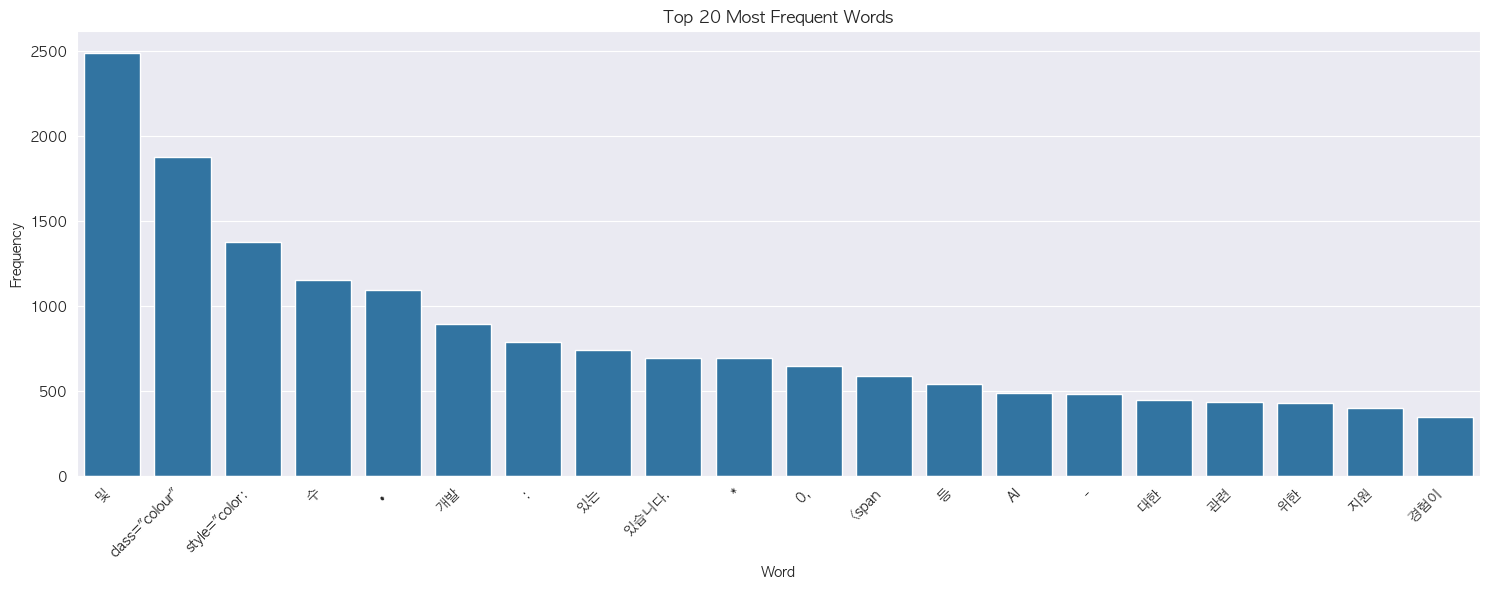

In [52]:
plt.figure(figsize=(15, 6))
sns.barplot(data=freq_df.head(20), x='Word', y='Frequency')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.tight_layout()
plt.show()

In [53]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(all_texts)

feature_names = tfidf.get_feature_names_out()
mean_tfidf = tfidf_matrix.mean(axis=0).A1

tfidf_df = pd.DataFrame({
    'Word': feature_names,
    'TF-IDF Score': mean_tfidf
})
tfidf_df = tfidf_df.sort_values('TF-IDF Score', ascending=False)

print("\nTop 20 words by TF-IDF score:")
print(tfidf_df.head(20))


Top 20 words by TF-IDF score:
       Word  TF-IDF Score
3619   span      0.049628
4562     개발      0.048766
14390    지원      0.043905
12945  있습니다      0.034856
5020     경험      0.026911
...     ...           ...
803      68      0.019559
5358     관련      0.019369
6816     대한      0.018664
3716     sw      0.018079
10396   시스템      0.017885

[20 rows x 2 columns]


In [54]:
def suggest_stopwords(freq_df, tfidf_df, threshold_freq=0.0001, threshold_tfidf=0.01):
    high_freq_words = set(freq_df[freq_df['Frequency'] > threshold_freq * freq_df['Frequency'].max()]['Word'])
    low_tfidf_words = set(tfidf_df[tfidf_df['TF-IDF Score'] < threshold_tfidf]['Word'])
    
    stopword_candidates = high_freq_words.intersection(low_tfidf_words)
    
    result_df = pd.DataFrame({
        'Word': list(stopword_candidates)
    })
    
    # 각 단어의 빈도와 TF-IDF 점수 추가
    result_df = result_df.merge(freq_df, on='Word', how='left')
    result_df = result_df.merge(tfidf_df, on='Word', how='left')
    
    return result_df.sort_values('Frequency', ascending=False)

# DataFrame 출력 옵션 설정
pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.width', None)  # 너비 제한 해제
pd.set_option('display.max_colwidth', None)  # 컬럼 너비 제한 해제

# 분석 실행
suggested_stopwords_df = suggest_stopwords(freq_df, tfidf_df)
print(suggested_stopwords_df.head(30))

       Word  Frequency  TF-IDF Score
10798   and        207      0.009458
2663   서비스를        161      0.008984
5736    글로벌        156      0.009466
6168    있도록        154      0.008683
6485   프로그램        150      0.009447
829      따라        149      0.007091
8738   프로젝트        143      0.009729
6183     등의        141      0.007418
6602     모델        140      0.008683
5082    새로운        132      0.008954
2924     서류        129      0.008824
5571     하는        127      0.006116
1300     투자        125      0.005613
10601  바탕으로        123      0.007896
269      모든        123      0.006371
8793     환경        120      0.009313
6571   서류전형        120      0.009781
6971    빠르게        120      0.005362
5528    딥러닝        118      0.009309
5403    필요한        118      0.004753
5791   자유로운        115      0.009984
2408    기반의        114      0.005743
6635   솔루션을        113      0.008245
2757     통한        113      0.007877
9808     장비        110      0.008676
2509    성장을        109      0.005383
8

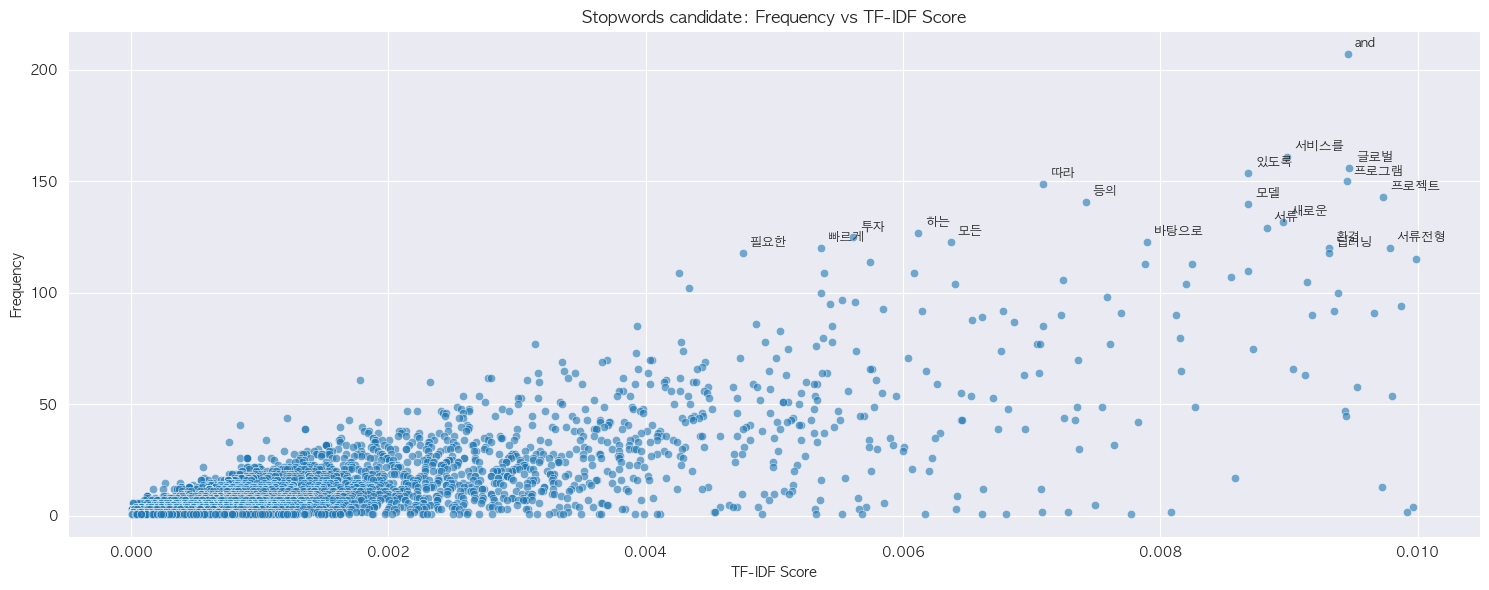

In [55]:
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')  # Mac용
# plt.rc('font', family='Malgun Gothic')  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

plt.figure(figsize=(15, 6))
sns.scatterplot(data=suggested_stopwords_df, x='TF-IDF Score', y='Frequency', alpha=0.6)
plt.title('Stopwords candidate: Frequency vs TF-IDF Score')

# 단어 레이블 추가
for i, row in suggested_stopwords_df.head(20).iterrows():
    plt.annotate(row['Word'], 
                (row['TF-IDF Score'], row['Frequency']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9)

plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [56]:
selected_stopwords = suggested_stopwords_df.head(30)['Word'].tolist()
print("Selected stopwords:", selected_stopwords)

def remove_selected_stopwords(text, stopwords):
    if not isinstance(text, str):
        return text
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

print("\nBefore deletion:")
print(merged.head())

text_columns = merged.select_dtypes(include=['object']).columns
for column in text_columns:
    merged[column] = merged[column].apply(lambda x: remove_selected_stopwords(x, selected_stopwords))

print("\nAfter deletion:")
print(merged.head())

def count_words(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

for column in text_columns:
    words_before = merged[column].apply(count_words).sum()
    words_after = merged[column].apply(count_words).sum()
    print(f"\n{column} column:")
    print(f"Removed words: {words_before - words_after}")

Selected stopwords: ['and', '서비스를', '글로벌', '있도록', '프로그램', '따라', '프로젝트', '등의', '모델', '새로운', '서류', '하는', '투자', '바탕으로', '모든', '환경', '서류전형', '빠르게', '딥러닝', '필요한', '자유로운', '기반의', '솔루션을', '통한', '장비', '성장을', '뛰어난', '문제를', '최적화', '활용한']

Before deletion:
                           title  \
1                  ML Researcher   
8             백엔드 개발자 / 이미지 프로세싱   
61  [울산] 풀스택 개발자 (nodejs, react)   
69                  AI  최적화 엔지니어   
78                    프론트엔드 엔지니어   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [57]:
merged.head()

,title,intro,category,comp_name,comp_addr,role,requirement,preferred,due,tech_stack,welfare,procedure
1,ML Researcher,"인공지능 스타트업 메이아이(mAy-I)에서 ML Researcher(머신러닝 연구원)을 모십니다! Position | ML Researcher Team | ML Research Team 경력 | 무관 대체복무 | 가능 * 메이아이는 이런 기업입니다 * make offline smart with AI 우리는 오프라인 매장의 방문객 데이터를 분석하는 인공지능 솔루션, 매쉬(mAsh)를 만드는 스타트업입니다. 수준 높고 정교한 매쉬는 어떠한 환경에서도 높은 정확도를 유지합니다. CVPR 논문 선정, CES 혁신상 수상 등 다방면의 성과가 우리의 기술력을 증명합니다. 2023년 하반기에는 60억 원 규모의 시리즈 A 유치를 성공적으로 마무리했습니다. 이를 기반으로, 빠른 시장 점유와 목전에 두고 있습니다. 우리의 멈추지 않는 성장에 속도를 더해 주실 탁월한 히치하이커를 찾습니다.",데이터 엔지니어|파이썬 개발자|머신러닝 엔지니어,메이아이,"서울 강남구 삼성로85길 26, V&S빌딩 5층","* 탁월하신 ML Researcher를 모십니다 *|메이아이의 ML Researcher는 타의 추종을 불허하는 매쉬의 독보적 기술력을 책임집니다. 객체 검출과 식별, 안정적인 재식별, 정확한 필터링과 데이터 분석까지. 메이아이의 ML Researcher는 매쉬를 어떤 환경에서도 분석이 가능한 인공지능으로 만듭니다.|주요 ML 모델의 정확도 향상을 위한 연구 및 개발|- 동영상으로부터 사람을 검출하고 추적하는 Human(object) Detector와 Multi-Human(object) Tracker|- 서로 다른 카메라에 나타난 동일인을 식별하는 Person Re-identifier|- 동영상에 나타난 사람들의 성별/연령대를 예측하는 Gender/age Estimator|- Person Re-identifier를 기반으로 각 인물의 공간 내 전체적인 동선을 추적하는 Multi-camera multi-object tracking|제품을 확장하고 고객 니즈를 충족하기 위한 기술 프로토타이핑, 연구 및 개발|- 예. 방문객이 어떤 상품과 상호 작용했는지 분석하는 기술, 방문객이 특정 광고물을 시청했는지를 분석하는 기술, 매장 관리를 위한 도난 및 위험 감지 기술|■ 채용 배경|메이아이의 영상 분석 시스템은 하루에 13,000시간의 영상을 처리하고, 하나의 매장에서 하루에 분석하는 방문객의 수는 최대 7~8만 명에 달합니다. 그리고 메이아이의 고객사는 지금 이 순간에도 늘어나고 있습니다. 고객사가 늘어난다는 것은 매쉬가 분석해야 영상의 양과 종류가 증가하는 것을 의미합니다.|다양한 변수가 존재하는 상황에서도 높은 성능을 유지하는 데에는 ML 모듈의 지속적 개선이 필요합니다. 따라서 ML Research Team은 탁월한 능력을 보유하신 ML Researcher를 모시고 다음과 같은 미션을 해결해 나가고자 합니다.|다양한 환경에서도 높은 정확도를 유지하는 ML 엔진 연구/개발|다양한 업종의 고객사를 만족시켜 시장성을 확보하는 ML 엔진 연구/개발|비용, 시간 등 최소한의 리소스를 소비하는 ML 엔진 연구/개발|메이아이는 시리즈 A 투자유치 성료를 통해 MVP를 증명했습니다. 그리고 이제 시리즈 B로 나아가는 과정에 올랐습니다. 메이아이의 가파르고 빠른 성장에 원동력이 되어주실 동료를 기다립니다.","메이아이의 ML Researcher는 기술의 최전선에서 일하며 매쉬를 강력하고 정교한 인공지능으로 만드는 직군입니다. 따라서 머신러닝 분야에서의 전문성이나, 그에 준하는 높은 수준의 역량이 요구됩니다. 보유하신 능력을 한계 없이 발휘하실 수 전폭적인 지원과 높은 의사결정권을 약속드립니다.|컴퓨터 비전 및 머신 러닝 분야 연구/개발 경력|필요한 분야의 논문을 읽고 적용하는 역량|수학/컴퓨팅 지식을 기반으로 정의하고, 그것을 해결하는 과정을 즐기는 성향|메이아이의 비전에 공감하는 마음","지원을 위한 필수 조건은 아니나, 보유하고 계시면 업무를 수행하실 때 큰 도움이 되는 역량입니다.|Object Detection, Multi-Object Tracking, Person Re-Identification, Age Estimation 도메인을 집중적으로 연구해 보신 경험|머신러닝 관련 연구를 진행하고 논문이나 특허를 작성해 보신 경험|대량의 영상 데이터를 연구 개발에 사용하고 관리해 보신 경험|컴퓨터 비전이나 멀티미디어 컴퓨팅에 대한 전문적인 지식|* ML Research Team은 이런 팀입니다 *|■ 이런 풀고 있습니다|ML Research Team이 중요하게 풀고 있는 문제는 앞서 기술한 바와 같이 다양한 환경에서도 방문객 데이터를 ‘더 정확하고’, ‘더 다양하게’ 추출할 수 있는 ML 엔진을 만들어 내는 것입니다.|여기서 ‘더 정확하게’란, 하루 평균 7~8만 명이 방문하는 공간, 구조가 복잡한 공간 등 챌린징한 환경에서도 정확한 데이터를 추출할 수 있는 ML 엔진을 만드는 것을 의미합니다.|‘더 다양하게’란 단순한 매장 방문 및 상품 매대 방문 이벤트를 넘어 상품을 얼마나 적극적으로 체험했는지, 광고를 얼마나 주의 깊게 시청했는지, 도난 특이 행동을 나타내지는 않았는지 등을 정량화하고 데이터화할 수 있는 ML 엔진을 만드는 것을 의미합니다.|더 다양하고 정확한 데이터로 오프라인 공간을 더 똑똑하게 만드는 것이 ML Researcher Team의 궁극적인 목표입니다.|■ 이렇게 함께 일합니다|메이아이는 에픽, 스토리, 테스크로 계층화된 업무 시스템을 활용합니다. 팀 전체가 에픽과 스토리를 정의하기 위해 논의하고 이를 달성하기 위한 테스크들을 각자 정의해 실행합니다.|테스크는 2주 단위(스프린트)로 관리됩니다. 매 스프린트의 시작에 초기화 미팅, 끝에 리뷰 미팅을 진행하여 진행 상황과 스케줄, 효율에 대해 이야기합니다.|ML Research Team은 팀 내에서 정의한 목표를 이루기 위해 각자 자유롭게 연구 방향성을 설정하고 연구하며, 결과를 통해 실력을 증명합니다. 또한 경우 특정 주제에 대한 세미나를 진행하는 등 혼자서 잘 것을 넘어 함께 성장하기 위해 노력합니다.|■ 이런 가치를 얻을 수 있습니다|메이아이의 ML Research Team은 기술력을 고성능 AI 엔진을 직접 개발하고 있습니다. 또한 업계 최고의 성능을 기록하며 국내 굴지의 대기업들을 만족시키고 있습니다.|ML Research Team은 ‘오프라인 공간의 방문객 데이터 분석’이라는 비전 아래 다양하고 고도화된 연구 활동을 지원합니다. 한 예로 2023년도 CVPR에 Human Object Interaction 분야의 논문을 발표하며 업계 최고 수준의 기술력을 증명한 바 있습니다.|따라서 ML Research Team에 합류하시게 되면 고객사의 다양한 니즈를 컴퓨터 비전 기술로 풀어내고, 연구 내용이 실제로 제품에 반영되어 가치를 제공하는 경험을 하실 수 있습니다. 무엇보다 이런 멋진 여정을 동료들과 함께할 수 있습니다. 메이아이의 현재 팀 문화에 더해, 능동적으로 다 같이 성장하기 위한 연구팀의 문화를 함께 만들어나갈 수 있습니다.",2024-11-30,멀티미디어|컴퓨터 비전|ML,"□ 최대의 자유 속에서 최고의 효율을 냅니다|핫타임 제도 : 저녁이 있는 삶? 아침도 있는 삶! 히치하이커는 평일 오후 1시부터 5시까지만 사무실에 상주합니다.|원격 근무 제도 : 핫타임 이외에는 원하는 곳에서 근무합니다. 각자 최대의 효율을 낼 수 있는 곳이라면 어디든 괜찮습니다.|유연 근무 제도 : 시간 불문 1주에 40시간을 회사에 기여합니다. 조용한 밤에 집중력이 오르는 부엉이도 상쾌한 아침에 에너지가 솟는 까치도 환영합니다.|전체 정렬 시스템 : 스프린트(2주) 단위로 업무를 관리합니다. 스프린트가 시작되는 첫 영업일에는 히치하이커가 모여 업무 상황을 공유합니다.|연차/반차 시스템 : 연차/반차를 사용할 때에는 사유를 알리거나 결제를 받지 않습니다. 휴식이 언제든 푹 쉬고 돌아 오세요.|리프레시 

# 6. Make correct type

In [58]:
def create_category_mapping():
    # from programmers
    category_data = [
        {"id": 1, "name": "서버/백엔드"},
        {"id": 4, "name": "프론트엔드"},
        {"id": 25, "name": "웹 풀스택"},
        {"id": 2, "name": "안드로이드"},
        {"id": 3, "name": "iOS"},
        {"id": 5, "name": "머신러닝"},
        {"id": 11, "name": "인공지능(AI)"},
        {"id": 12, "name": "데이터 엔지니어링"},
        {"id": 92, "name": "DBA"},
        {"id": 7, "name": "모바일 게임"},
        {"id": 16, "name": "게임 클라이언트"},
        {"id": 20, "name": "게임 서버"},
        {"id": 9, "name": "시스템/네트워크"},
        {"id": 18, "name": "시스템 소프트웨어"},
        {"id": 59, "name": "데브옵스"},
        {"id": 22, "name": "인터넷 보안"},
        {"id": 26, "name": "임베디드 소프트웨어"},
        {"id": 27, "name": "로보틱스 미들웨어"},
        {"id": 10, "name": "QA"},
        {"id": 13, "name": "사물인터넷(IoT)"},
        {"id": 17, "name": "응용 프로그램"},
        {"id": 6, "name": "블록체인"},
        {"id": 125, "name": "개발PM"},
        {"id": 126, "name": "웹 퍼블리싱"},
        {"id": 127, "name": "크로스 플랫폼"},
        {"id": 128, "name": "VR/AR/3D"},
        {"id": 129, "name": "ERP"},
        {"id": 130, "name": "그래픽스"}
    ]
    return {str(item["id"]): item["name"] for item in category_data}

def map_categories(csv):
    category_map = create_category_mapping()
    
    def convert_categories(category_str):
        if pd.isna(category_str):
            return ""
        categories = category_str.split('|')
        mapped_categories = [category_map.get(cat, cat) for cat in categories]
        return '|'.join(mapped_categories)
    
    csv['category'] = csv['category'].apply(convert_categories)
    
    return merged

In [59]:
map_categories(merged)

# 7. Save as CSV

In [60]:
merged.to_csv('./data/cleaned_data.csv', index=False, encoding='utf-8-sig')

print(f"{len(merged)} column saved")